In [1]:
import os
import pandas as pd
import numpy as np
from glob import glob
from PIL import Image
import matplotlib.pyplot as plt


In [2]:
folder_MOT17 = '/home/mvlab/Downloads/dataset/MOT/'
folder_Det = folder_MOT17 + 'MOT17Det/train/'

In [3]:
os.path.isdir(folder_MOT17), os.path.isfile(folder_Det)

(True, False)

In [4]:
folders_video = glob(folder_Det + '*')
folders_video

['/home/mvlab/Downloads/dataset/MOT/MOT17Det/train/MOT17-02',
 '/home/mvlab/Downloads/dataset/MOT/MOT17Det/train/MOT17-05',
 '/home/mvlab/Downloads/dataset/MOT/MOT17Det/train/MOT17-13',
 '/home/mvlab/Downloads/dataset/MOT/MOT17Det/train/MOT17-11',
 '/home/mvlab/Downloads/dataset/MOT/MOT17Det/train/MOT17-09',
 '/home/mvlab/Downloads/dataset/MOT/MOT17Det/train/MOT17-04',
 '/home/mvlab/Downloads/dataset/MOT/MOT17Det/train/MOT17-10']

In [23]:
def get_MOT17_df(folder_video):    
    video = folder_video.split(os.sep)[-1]
    print('video', video)
    path_annot = folder_video + '/gt/gt.txt'
        
    df = pd.read_csv(path_annot, header=None, names=['frame','id','x','y','w','h','d0','d1','d2'])
    df['video'] = video + '/img1/'
    print('shape', df.shape)
    return df

In [27]:
list_df = []
for folder_video in folders_video:
    df = get_MOT17_df(folder_video)
    list_df.append(df)
len(list_df)

video MOT17-02
shape (30003, 10)
video MOT17-05
shape (8013, 10)
video MOT17-13
shape (20202, 10)
video MOT17-11
shape (10617, 10)
video MOT17-09
shape (10411, 10)
video MOT17-04
shape (108005, 10)
video MOT17-10
shape (17450, 10)


7

In [29]:
df = pd.concat(list_df)
df.shape

(204701, 10)

In [30]:
df.head(2)

,frame,id,x,y,w,h,d0,d1,d2,video
0,1,1,912,484,97,109,0,7,1.0,MOT17-02/img1/
1,2,1,912,484,97,109,0,7,1.0,MOT17-02/img1/


In [31]:
list_img_names = []
for frame in df.frame.values:
    img_file_name = '%#06d' % frame + '.jpg'
    list_img_names.append(img_file_name)
df['img'] = list_img_names

In [32]:
df = df.sort_values('video')

In [33]:
df.head().values

array([[1, 1, 912, 484, 97, 109, 0, 7, 1.0, 'MOT17-02/img1/',
        '000001.jpg'],
       [141, 46, 695, 462, 25, 67, 0, 7, 0.0, 'MOT17-02/img1/',
        '000141.jpg'],
       [140, 46, 695, 462, 25, 67, 0, 7, 0.0, 'MOT17-02/img1/',
        '000140.jpg'],
       [139, 46, 695, 462, 25, 67, 0, 7, 0.0, 'MOT17-02/img1/',
        '000139.jpg'],
       [138, 46, 695, 462, 25, 67, 0, 7, 0.0, 'MOT17-02/img1/',
        '000138.jpg']], dtype=object)

In [34]:
def visualize_detections_simple(
    image, boxes, classes, figsize=(12, 12), linewidth=1, color=[0, 0, 1]
):
    """Visualize Detections"""
    image = np.array(image, dtype=np.uint8)    
    
    img_h, img_w, img_c = image.shape
    
    #image = attach_crop_image(image, boxes, max_crop=100)
    
    plt.figure(figsize=figsize)
    plt.axis("off")
    plt.imshow(image)
    ax = plt.gca()
    boxes_width = boxes[:, 2] - boxes[:, 0]
    boxes_height = boxes[:, 3] - boxes[:, 1]
    box_min_width = np.min(boxes_width)
    box_max_width = np.max(boxes_width)
    title = str.format('(%dx%d) %d box, width:%d ~ %d' 
                       %(img_h, img_w, len(boxes), box_min_width, box_max_width))
    plt.title(title)
    for box, cls in zip(boxes, classes):
        x1, y1, w, h = box        
        
        color = (1, 1, 1)
        if w > h*0.7:
            color = (1, 0, 0)
        patch = plt.Rectangle(
            [x1, y1], w, h, fill=False, edgecolor=color, linewidth=linewidth
        )
        ax.add_patch(patch)
        if len(boxes) < 700:
            #score_txt = class_names[int(cls)]
            score_txt = str(cls)
            ax.text(x1, y1, score_txt, bbox={"facecolor": [1,1,0], "alpha": 0.4}, clip_box=ax.clipbox, clip_on=True,)
        
    plt.show()
    return ax

def display_data(X, BBOX, stride=1):
    for i in range(len(X)):
        if i%stride==0:
            img_arr = X[i]
            sample_box = BBOX[i]
            label = sample_box[:, 0]
            bbox = sample_box[:, 1:1+4]

            h, w, c = img_arr.shape
            scale = np.array((w, h, w, h))
            scale = np.reshape(scale, (1, 4))
            bbox_norm = bbox.astype(np.float)# * scale.astype(np.float)
            #print('bbox_norm', bbox, bbox_norm)
            #print(i, np.unique(label))
            ax = visualize_detections_simple(img_arr,bbox_norm,label)

In [35]:
(df['frame']==1).sum()

246

In [36]:
cond_person = df.d0 == 1
cond_not_person = df.d0 == 0
cond_wide = df.w > df.h * 0.7
cond_car = np.logical_and(cond_not_person, cond_wide)

len(df), cond_person.sum()/len(df), cond_car.sum()/len(df)

(204701, 0.5485903830464922, 0.18290579919003816)

In [37]:
df['cls']='bg'
df.loc[cond_person, 'cls']='person'
df.loc[cond_car, 'cls']='car'

In [38]:
df

,frame,id,x,y,w,h,d0,d1,d2,video,img,cls
0,1,1,912,484,97,109,0,7,1.00000,MOT17-02/img1/,000001.jpg,car
20010,141,46,695,462,25,67,0,7,0.00000,MOT17-02/img1/,000141.jpg,bg
20009,140,46,695,462,25,67,0,7,0.00000,MOT17-02/img1/,000140.jpg,bg
20008,139,46,695,462,25,67,0,7,0.00000,MOT17-02/img1/,000139.jpg,bg
20007,138,46,695,462,25,67,0,7,0.00000,MOT17-02/img1/,000138.jpg,bg
...,...,...,...,...,...,...,...,...,...,...,...,...
10267,5,80,1088,517,148,54,0,3,0.48164,MOT17-13/img1/,000005.jpg,car
10266,4,80,1113,516,137,54,0,3,0.56653,MOT17-13/img1/,000004.jpg,car
10265,3,80,1129,514,135,55,0,3,0.63078,MOT17-13/img1/,000003.jpg,car
10353,60,81,1087,528,165,59,0,3,0.79347,MOT17-13/img1/,000060.jpg,car


In [42]:
df.video.nunique(), df.video.unique()

(7,
 array(['MOT17-02/img1/', 'MOT17-04/img1/', 'MOT17-05/img1/',
        'MOT17-09/img1/', 'MOT17-10/img1/', 'MOT17-11/img1/',
        'MOT17-13/img1/'], dtype=object))

In [43]:
def display_frame_gt(video=0, frame=1):
        
    video_name = df.video.unique()[video]
    cond_0 = df['video'] == video_name
    cond_1 = df['frame'] == frame
    cond = np.logical_and(cond_0, cond_1)
    
    df_1 = (df[cond])
    
    cond = df_1['cls']!='bg'
    
    bboxes = df_1[['cls','x','y','w','h']].values
    bbox = bboxes[cond]        
        
    path_img = folder_Det + df_1.iloc[0].video + df.img.iloc[0]
    print('path_img', path_img)
    
    if not os.path.isfile(path_img):
        print('not exist', path_img)
        return
    
    x = np.array(Image.open(path_img))
    X = np.expand_dims(x, 0)
    Y = np.expand_dims(bbox, 0)
    #X.shape, bbox.values.shape
    display_data(X, Y)
    

path_img /home/mvlab/Downloads/dataset/MOT/MOT17Det/train/MOT17-02/img1/000001.jpg


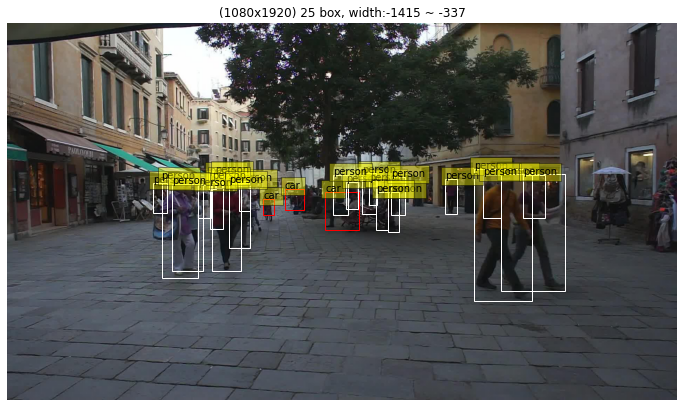

In [44]:
display_frame_gt(video=0, frame=1)